# ChurnGuard: Predicting Customer Churn in Banking with Binary Classification

In [164]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split       
from sklearn.linear_model import LogisticRegression, Ridge, Lasso 

In [178]:
train = pd.read_csv('train.csv')
y_train = train['Exited']

test = pd.read_csv('test.csv')
Id = test['id']


In [194]:
def get_Features(df): 
    df["Surname_First_Letter"] = df["Surname"].apply(lambda x: x[0])
    df["Age_NumOfProducts"] = df["Age"] ** df["NumOfProducts"] 
    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0) 
    df['TenureToAgeRatio'] = df['Tenure'] / df['Age'] 
    df['Balance_to_Salary_Ratio'] = df['Balance'] / df['EstimatedSalary'] 
    df["Surname_Length"] = df["Surname"].apply(lambda x: len(x))
    df['HighCreditScore'] = df['CreditScore'].apply(lambda x: 1 if x >= 800 else 0)
    df['Age_Product_Interact'] = df['Age'] * df['NumOfProducts']
    df['AvgBalancePerProduct'] = df['Balance'] / (df['NumOfProducts'] +1e-9) 

    df['HighAvgBalancePerProduct'] = df['AvgBalancePerProduct'].apply(lambda x: 1 if x >= 5000 else 0)
    df['TenureCategory'] = pd.cut(df['Tenure'], bins=[-1, 2, 5, 10, np.inf], labels=['Short', 'Medium', 'Long', 'Very Long']).astype('object')
    df['BalanceCategory'] = pd.cut(df['Balance'], bins=[-1, 50000, 100000, 150000, np.inf], labels=['Low', 'Medium', 'High', 'Very High']).astype('object')
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember'] 
    df['Products_Per_Tenure'] = df['Tenure'] / df['NumOfProducts'] 
    df['AgeCat'] = np.round(df.Age/20).astype('int').astype('object')
    df['HighBalanceToSalaryRatio'] = df['Balance_to_Salary_Ratio'].apply(lambda x: 1 if x >= 0.5 else 0)
    df['ActiveMember_with_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']


    return df

In [180]:
train_ = get_Features(train)
test = get_Features(test)
train_ = train_.drop(columns=['id','CustomerId','Surname','Exited'], axis=1)
test = test.drop(columns=['id','CustomerId','Surname'], axis=1)

train_obj = train_.select_dtypes(include=['object']).columns.tolist()
test_obj = test.select_dtypes(include=['object']).columns.tolist()

train_encoded = pd.get_dummies(train_, train_obj).astype(int)
test_encoded = pd.get_dummies(test, test_obj,).astype(int)



train,test = train_encoded,test_encoded


X_train, X_val, y_train, y_val = train_test_split(train, y_train, test_size=0.2, random_state=42)


In [181]:
best_params = {'subsample': 0.9,
 'seed': 42,
 'scale_pos_weight': 4,
 'objective': 'binary:logistic',
 'n_jobs': 1,
 'n_estimators': 400,
 'min_child_weight': 3,
 'max_depth': 4,
 'learning_rate': 0.05,
 'lambda': 1.5,
 'gamma': 0.2,
 'eval_metric': 'logloss',
 'colsample_bytree': 0.8,
 'alpha': 0.1}

# Use the same data split as in the grid search

# Use the same random state for the XGBClassifier
model = XGBClassifier(**best_params, random_state=42).fit(X_train, y_train)
predictions_train = model.predict_proba(X_train)[:,1]
predictions_val = model.predict_proba(X_val)[:,1]

#predictions_val = model.predict_proba(X_val)[:,1]

# Calculate and print the ROC AUC score
auc_score = roc_auc_score(y_train, predictions_train)
auc_score_val = roc_auc_score(y_val, predictions_val)

print(f'ROC AUC Score (train) = {auc_score}')
print(f'ROC AUC Score (validation) = {auc_score_val}')



ROC AUC Score (train) = 0.8979025410696928
ROC AUC Score (validation) = 0.8928066805061559


In [195]:

yhat = model.predict_proba(test)[:,1]
with open('submission.csv','w',newline='') as csvfile:
    csvv = csv.writer(csvfile)
    csvv.writerow(['id','Exited'])

    for i in range((len(test))):
        csvv.writerow([Id[i],yhat[i]])


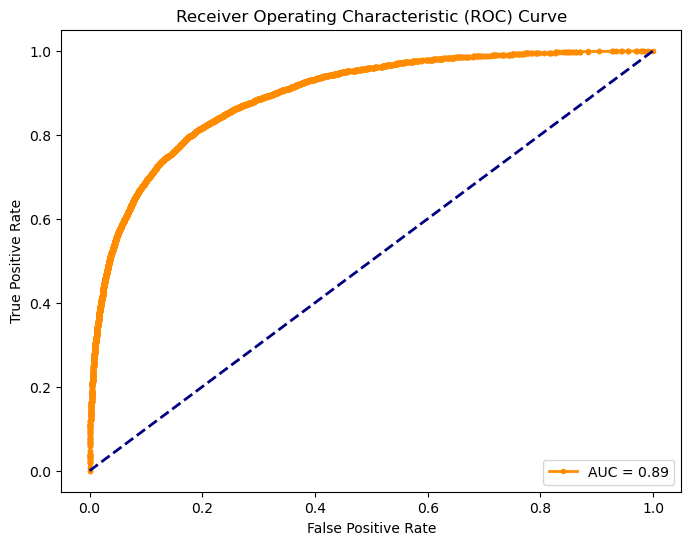

In [183]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, predictions_val)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.',color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

